In [158]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from textblob import TextBlob
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.svm import SVC, LinearSVC
# from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
# from sklearn.pipeline import Pipeline
# from sklearn.grid_search import GridSearchCV
# from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
# from sklearn.tree import DecisionTreeClassifier 
# from sklearn.learning_curve import learning_curve

/Users/ANTARES/anaconda2/envs/snakes/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/ANTARES/anaconda2/envs/snakes/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/ANTARES/anaconda2/envs/snakes/lib/python3.5/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are 

In [159]:
# We use the Pandas library to read the contents of the scraped data
# obtained by Scrapy
df_basic = pd.read_csv('hotel_sentiment/itemsTripadvisor.csv', encoding='utf-8')

# Now we remove duplicate rows (reviews)
df_basic.drop_duplicates(inplace=True)

In [160]:
df_basic.columns

Index(['title', 'stars', 'content'], dtype='object')

In [161]:
df_basic.shape

(20010, 3)

# Cleaning

In [24]:
# Drop the reviews with 3 stars, since we're doing Positive/Negative
# sentiment analysis for a supervised classifier.
# df = df_basic[df_basic['stars'] != '3 of 5 bubbles']

In [262]:
df = df_basic.copy(deep=True)

In [263]:
pd.isnull(df).any(1).nonzero()[0]

array([4428])

In [264]:
df[4427:4429]

,title,stars,content
4427,amazing hotel with small rooms and amazing coc...,4 of 5 bubbles,\nI visited Baccarat Hotel last march
4428,NaN,2 of 5 bubbles,\ndisappointed with service. Details are above...


In [265]:
df.title[4428] = ""

In [266]:
df.title[4428]

''

In [267]:
# Concat the review and title
df['full_content'] = df['title'] + ". " + df['content']

In [268]:
# def get_class(stars):
#     score = int(stars[0])
#     if score > 3:
#         return 'Good'
#     else:
#         return 'Bad'
    
# # Transform the number of stars into Good and Bad tags.
# df['true_category'] = df['stars'].apply(get_class)

In [269]:
df.shape

(20010, 4)

In [270]:
df.head()

,title,stars,content,full_content
0,Small room big beds,4 of 5 bubbles,"\nAfter we got used to the cramped quarters, I...",Small room big beds. \nAfter we got used to th...
1,GREAT FIND,5 of 5 bubbles,\nWanted something a little away from Midtown;...,GREAT FIND. \nWanted something a little away f...
2,Wonderful Stay,5 of 5 bubbles,\nWe spent our wedding night at the Pierre and...,Wonderful Stay. \nWe spent our wedding night a...
3,Fantastic funky hotel!,5 of 5 bubbles,\nWhat a funky modern hotel. Check was so easy...,Fantastic funky hotel!. \nWhat a funky modern ...
4,All around wonderful experience,5 of 5 bubbles,\nRecently stayed at the hotel for a meeting a...,All around wonderful experience. \nRecently st...


In [271]:
df['stars'].value_counts()

5 of 5 bubbles    14526
4 of 5 bubbles     3853
3 of 5 bubbles     1053
2 of 5 bubbles      354
1 of 5 bubbles      224
Name: stars, dtype: int64

In [272]:
df.stars[0]

'4 of 5 bubbles'

In [273]:
def get_class(stars):
    score = int(stars[0])
    if score == 5:
        return 5
    elif score == 4:
        return 4
    elif score == 3:
        return 3
    elif score == 2:
        return 2
    elif score == 1:
        return 1
    else:
        return -9
    
# Transform the number of stars into Good and Bad tags.
df['rating'] = df['stars'].apply(get_class)

In [274]:
df.rating.value_counts()

5    14526
4     3853
3     1053
2      354
1      224
Name: rating, dtype: int64

In [275]:
df.groupby('rating').describe()

content  \
rating                                                             
1      count                                                 224   
       unique                                                224   
       top     \nIn many ways the hotel is great. But they do...   
       freq                                                    1   
2      count                                                 354   
       unique                                                354   
       top     \nI had the opportunity to visit the refinery ...   
       freq                                                    1   
3      count                                                1053   
       unique                                               1051   
       top                                                    \n   
       freq                                                    3   
4      count                                                3853   
       unique                                               3853   
       top     \nThe hotel is spacious, in an exceptional pos...   
       freq                                                    1   
5      count                                               14526   
       unique                                              14517   
       top                                                    \n   
       freq                                                    8   

                                                    full_content  \
rating                                                             
1      count                                                 224   
       unique                                                224   
       top     Horrible Experience. \nFirst of all, the stay ...   
       freq                                                    1   
2      count                                                 354   
       unique                                                354   
       top     Changed for the worse. \nA few years ago, my w...   
       freq                                                    1   
3      count                                                1053   
       unique                                               1053   
       top     Beautiful & Clean With A Major Issue. \nThe Lo...   
       freq                                                    1   
4      count                                                3853   
       unique                                               3853   
       top     Great hotel, but lost battery charger from the...   
       freq                                                    1   
5      count                                               14526   
       unique                                              14526   
       top     Marvellous!. \nJust the best hotel we stayed i...   
       freq                                                    1   

                        stars           title  
rating                                         
1      count              224             224  
       unique               1             221  
       top     1 of 5 bubbles    Never again.  
       freq               224               2  
2      count              354             354  
       unique               1             345  
       top     2 of 5 bubbles   Disappointing  
       freq               354               5  
3      count             1053            1053  
       unique               1            1004  
       top     3 of 5 bubbles   Disappointing  
       freq              1053               7  
4      count             3853            3853  
       unique               1            3501  
       top     4 of 5 bubbles  Great location  
       freq              3853              32  
5      count            14526           14526  
       unique               1           11986  
       top     5 of 5 bubbles     Great hotel  
       freq             14526              79

In [276]:
df['length'] = df['full_content'].map(lambda text: len(text))
df.head()

,title,stars,content,full_content,rating,length
0,Small room big beds,4 of 5 bubbles,"\nAfter we got used to the cramped quarters, I...",Small room big beds. \nAfter we got used to th...,4,255
1,GREAT FIND,5 of 5 bubbles,\nWanted something a little away from Midtown;...,GREAT FIND. \nWanted something a little away f...,5,275
2,Wonderful Stay,5 of 5 bubbles,\nWe spent our wedding night at the Pierre and...,Wonderful Stay. \nWe spent our wedding night a...,5,276
3,Fantastic funky hotel!,5 of 5 bubbles,\nWhat a funky modern hotel. Check was so easy...,Fantastic funky hotel!. \nWhat a funky modern ...,5,224
4,All around wonderful experience,5 of 5 bubbles,\nRecently stayed at the hotel for a meeting a...,All around wonderful experience. \nRecently st...,5,241


# Data Exploration

/Users/ANTARES/anaconda2/envs/snakes/lib/python3.5/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


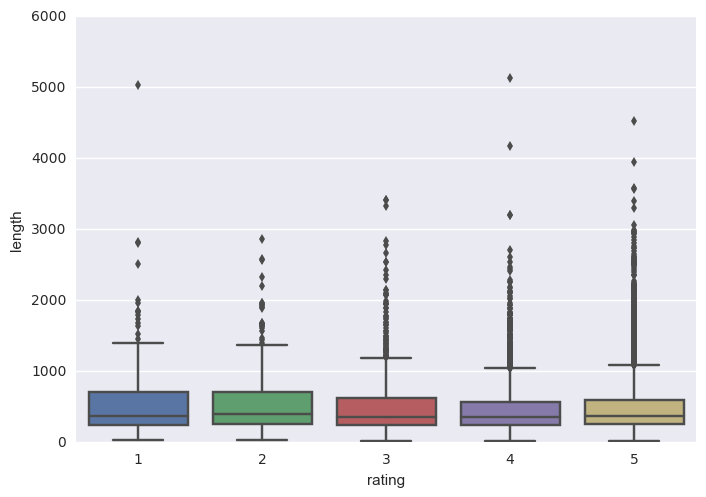

In [286]:
sns.boxplot(df.length, groupby=df.rating)

In [287]:
# Regardless of eventual rating, generally reviews are of similar length (worse may be longer)

# Sentiment Analysis

In [277]:
df['polarity'] = df.apply(lambda x: TextBlob(x['full_content']).sentiment.polarity, axis=1)
df['subjectivity'] = df.apply(lambda x: TextBlob(x['full_content']).sentiment.subjectivity, axis=1)

In [278]:
df.head()

,title,stars,content,full_content,rating,length,polarity,subjectivity
0,Small room big beds,4 of 5 bubbles,"\nAfter we got used to the cramped quarters, I...",Small room big beds. \nAfter we got used to th...,4,255,0.189063,0.558333
1,GREAT FIND,5 of 5 bubbles,\nWanted something a little away from Midtown;...,GREAT FIND. \nWanted something a little away f...,5,275,0.391121,0.610714
2,Wonderful Stay,5 of 5 bubbles,\nWe spent our wedding night at the Pierre and...,Wonderful Stay. \nWe spent our wedding night a...,5,276,0.390278,0.700000
3,Fantastic funky hotel!,5 of 5 bubbles,\nWhat a funky modern hotel. Check was so easy...,Fantastic funky hotel!. \nWhat a funky modern ...,5,224,0.325298,0.619048
4,All around wonderful experience,5 of 5 bubbles,\nRecently stayed at the hotel for a meeting a...,All around wonderful experience. \nRecently st...,5,241,0.637500,0.691667


In [280]:
import seaborn as sns

/Users/ANTARES/anaconda2/envs/snakes/lib/python3.5/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


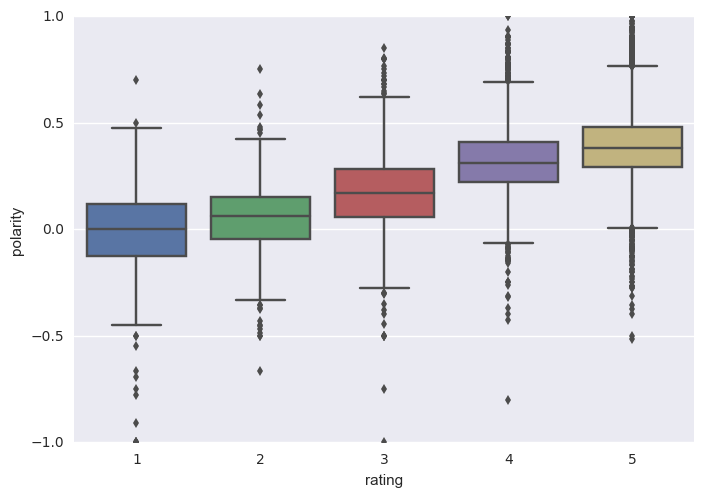

In [281]:
sns.boxplot(df.polarity, groupby=df.rating)

/Users/ANTARES/anaconda2/envs/snakes/lib/python3.5/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


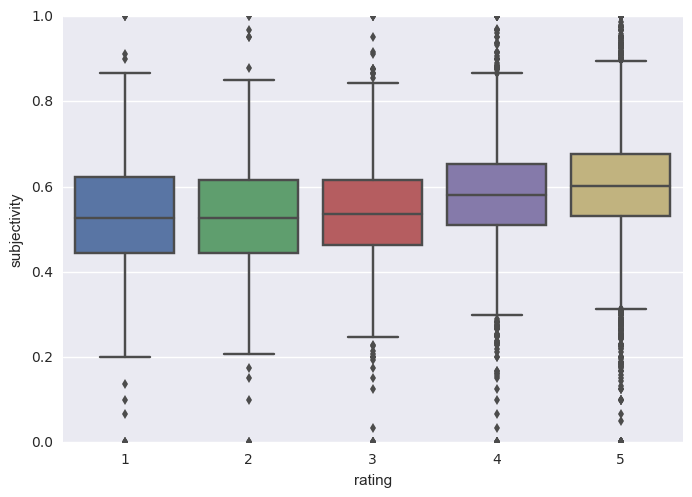

In [282]:
sns.boxplot(df.subjectivity, groupby=df.rating)

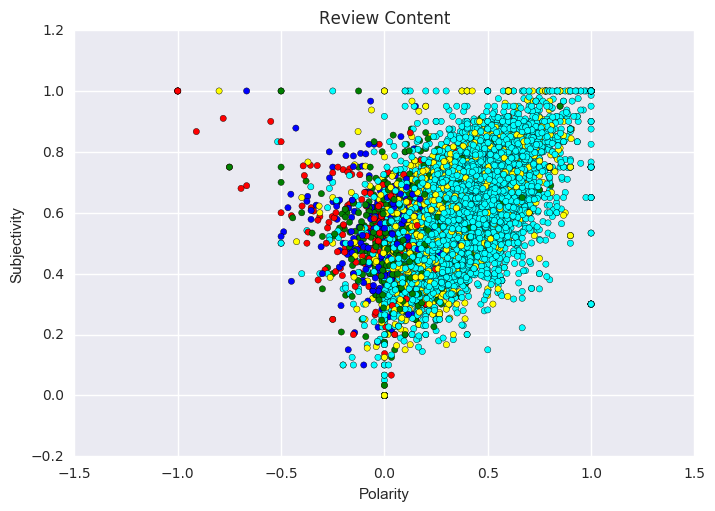

In [283]:
fig, ax = plt.subplots()

colors = {1:'red', 2:'blue', 3:'green', 4:'yellow', 5:'cyan'}
ax.scatter(df['polarity'], df['subjectivity'], c=df['rating'].apply(lambda x: colors[x]))

title = "Review Content"
ax.set_title(title)
ax.set_xlabel('Polarity')
ax.set_ylabel('Subjectivity')

plt.show()

# Topic Modeling

In [54]:
# !pip install --upgrade gensim

    100% |████████████████████████████████| 4.3MB 93kB/s 
Requirement already up-to-date: scipy>=0.7.0 in /Users/ANTARES/anaconda2/envs/snakes/lib/python3.5/site-packages (from gensim)
Requirement already up-to-date: smart-open>=1.2.1 in /Users/ANTARES/anaconda2/envs/snakes/lib/python3.5/site-packages (from gensim)
Requirement already up-to-date: six>=1.5.0 in /Users/ANTARES/anaconda2/envs/snakes/lib/python3.5/site-packages (from gensim)
Requirement already up-to-date: numpy>=1.3 in /Users/ANTARES/anaconda2/envs/snakes/lib/python3.5/site-packages (from gensim)
    100% |████████████████████████████████| 1.4MB 245kB/s 
Requirement already up-to-date: bz2file in /Users/ANTARES/anaconda2/envs/snakes/lib/python3.5/site-packages (from smart-open>=1.2.1->gensim)
Requirement already up-to-date: requests in /Users/ANTARES/anaconda2/envs/snakes/lib/python3.5/site-packages (from smart-open>=1.2.1->gensim)
  Found existing installation: gensim 0.12.4
    Uninstalling gensim-0.12.4:
      Successf

In [204]:
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim import corpora, models, similarities, matutils

In [219]:
count_vectorizer = CountVectorizer(analyzer='word',
                                  ngram_range=(1, 1), stop_words='english',
                                  min_df=1)
count_vectorizer.fit(doc_list)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [220]:
count_vectorizer.vocabulary_

{'attitdue': 1883,
 'broadband': 2960,
 'kyle': 10447,
 'spec': 17037,
 '2005': 230,
 'repeat': 15176,
 'downstairs': 6022,
 'crews': 4913,
 'viola': 19530,
 'occupy': 12712,
 'fractionally': 7772,
 'clearing': 3945,
 'bake': 2111,
 'oark': 12641,
 'kaos': 10233,
 'opulence': 12896,
 '55': 508,
 'satisfactorily': 15883,
 'drugstores': 6132,
 'awfully': 2022,
 'seoul': 16172,
 'jetluxuryresorts': 10078,
 'dragged': 6038,
 'waiter': 19647,
 'spend': 17081,
 'astonishingly': 1810,
 'loudest': 11026,
 'traipsing': 18609,
 'series': 16205,
 'currency': 5054,
 'cupano': 5033,
 'rebated': 14739,
 'slices': 16676,
 'describes': 5474,
 'promptlychecked': 14303,
 'itbwasntba': 9951,
 'conexión': 4411,
 '530': 502,
 '55th': 510,
 'mondays': 11948,
 'daiquiri': 5122,
 'offices': 12754,
 'pun': 14417,
 'forthcoming': 7733,
 'hysterical': 9277,
 'feat': 7274,
 'overtly': 13100,
 'portuguese': 13935,
 'articulated': 1716,
 'application': 1579,
 'fussy': 7991,
 'champers': 3582,
 'husbands': 9251,
 'b

In [206]:
doc_list = df['content']

In [221]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                  ngram_range=(1, 2), stop_words='english',
                                  min_df=10)

tfidf_vectorizer.fit(doc_list)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=10,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [222]:
doc_vecs = tfidf_vectorizer.transform(doc_list).transpose()
doc_vecs.shape

(12449, 20010)

In [223]:
tfidf_vectorizer.get_feature_names()

['00',
 '00 pm',
 '000',
 '00am',
 '00pm',
 '10',
 '10 10',
 '10 15',
 '10 30',
 '10 days',
 '10 min',
 '10 mins',
 '10 minute',
 '10 minutes',
 '10 nights',
 '10 year',
 '10 years',
 '100',
 '1000',
 '1000 night',
 '10am',
 '10pm',
 '10th',
 '10th floor',
 '10th wedding',
 '11',
 '11 memorial',
 '11 nights',
 '11am',
 '11pm',
 '11th',
 '11th floor',
 '12',
 '12 nights',
 '12 year',
 '12th',
 '12th floor',
 '13',
 '13 year',
 '13th',
 '14',
 '14 day',
 '14th',
 '14th floor',
 '14th st',
 '14th street',
 '15',
 '15 20',
 '15 day',
 '15 min',
 '15 mins',
 '15 minute',
 '15 minutes',
 '15 year',
 '15 years',
 '150',
 '15th',
 '15th floor',
 '16',
 '16 year',
 '16th',
 '16th floor',
 '17',
 '17th',
 '17th floor',
 '18',
 '18th',
 '18th birthday',
 '18th floor',
 '19',
 '19th',
 '19th floor',
 '1am',
 '1pm',
 '1st',
 '1st floor',
 '1st time',
 '20',
 '20 minute',
 '20 minutes',
 '20 years',
 '200',
 '200 night',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '20th',
 '20th 

In [224]:
corpus = matutils.Sparse2Corpus(doc_vecs)

In [225]:
corpus

In [226]:
id2word = dict((v, k) for k, v in tfidf_vectorizer.vocabulary_.items())

In [227]:
len(id2word)

12449

In [228]:
lda = models.LdaModel(corpus, id2word=id2word, num_topics=12, passes=4, alpha='auto', eta='auto')

In [300]:
# lda.print_topics(num_words=20, num_topics=12)

In [234]:
sorted(lda.show_topic(0, topn=12), key=lambda x: x[1], reverse=True) [:12]

[('significant', 8.5602492157649674e-05),
 ('wow factor', 8.346607815071595e-05),
 ('ticked boxes', 8.1577523418366709e-05),
 ('ticked', 8.156298474705559e-05),
 ('funky', 8.1404604201464246e-05),
 ('pet', 8.1369827042571864e-05),
 ('boxes', 8.127293398544533e-05),
 ('pet friendly', 8.1268137593255063e-05),
 ('11th', 8.1011987169573801e-05),
 ('gives', 8.0975547693940618e-05),
 ('dog', 8.0971889522051741e-05),
 ('stayed beautiful', 8.0971339879593932e-05)]

In [235]:
sorted(lda.show_topic(1, topn=12), key=lambda x: x[1], reverse=True) [:12]

[('hotel', 0.0029452479090123075),
 ('room', 0.001931388885041668),
 ('staff', 0.001772884757927162),
 ('great', 0.0014060315038581868),
 ('stay', 0.0014031677182707689),
 ('helpful', 0.0014010787534962515),
 ('stayed', 0.0012827284715773006),
 ('friendly', 0.0012776043211802071),
 ('location', 0.001246284085105992),
 ('nyc', 0.0012253944373248201),
 ('just', 0.0011983964300499932),
 ('new', 0.0011737156219766005)]

In [292]:
sorted(lda.show_topic(2, topn=25), key=lambda x: x[1], reverse=True) [:25]

[('pros', 0.00024328197986411932),
 ('really feel', 8.3593474692502629e-05),
 ('kong', 8.2679670147911419e-05),
 ('hong', 8.2633613425214805e-05),
 ('hong kong', 8.2633613424605592e-05),
 ('gives', 8.2551444980025283e-05),
 ('lord taylor', 8.2024417346788828e-05),
 ('lord', 8.2021462828278435e-05),
 ('taylor', 8.1909957414923374e-05),
 ('factory', 8.1651492889444721e-05),
 ('hat', 8.1499777359647993e-05),
 ('hat factory', 8.13542904190763e-05),
 ('nights july', 8.1318534712368102e-05),
 ('room location', 8.1123368703095225e-05),
 ('currently', 8.1053655340919794e-05),
 ('currently staying', 8.1035179184982863e-05),
 ('trip ny', 8.1025876874123271e-05),
 ('yorkers', 8.1006925293756237e-05),
 ('new yorkers', 8.100692529221911e-05),
 ('cons', 8.0954544187554364e-05),
 ('nice rooms', 8.0926255327582283e-05),
 ('surrounding', 8.0855157920292007e-05),
 ('surrounding area', 8.0843557085557628e-05),
 ('calls', 8.0830202295293347e-05),
 ('confortable', 8.0815251032749686e-05)]

In [291]:
sorted(lda.show_topic(3, topn=25), key=lambda x: x[1], reverse=True) [:25]

[('clients', 8.7548293105206999e-05),
 ('uws', 8.1176049920715358e-05),
 ('nylo', 8.1124668538380394e-05),
 ('favourite hotel', 8.1114458359870129e-05),
 ('love place', 8.1046087445219898e-05),
 ('bed excellent', 8.0978442949559528e-05),
 ('staff nicer', 8.0954886223509194e-05),
 ('favourite', 8.0945986918765344e-05),
 ('great bed', 8.0929228793383989e-05),
 ('positives', 8.0899843884387783e-05),
 ('great price', 8.0893350989906111e-05),
 ('clean great', 8.0884052975502328e-05),
 ('opportunity', 8.0832534758727142e-05),
 ('opportunity stay', 8.0829807334916105e-05),
 ('garage', 8.077816032753176e-05),
 ('fell', 8.0776100136671633e-05),
 ('nicer', 8.076051502687696e-05),
 ('mood', 8.0757706903764962e-05),
 ('just love', 8.0748394338244641e-05),
 ('nice restaurant', 8.071703067847859e-05),
 ('hip', 8.0715627918700341e-05),
 ('experience excellent', 8.069783175263121e-05),
 ('fell love', 8.068471034365628e-05),
 ('hotel upper', 8.0671109248123569e-05),
 ('close restaurants', 8.06693389446

In [240]:
# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus = lda[corpus]

In [307]:
lda_docs = [doc for doc in lda_corpus]

In [308]:
len(lda_docs)

20010

In [310]:
lda_docs[12000]

[(1, 0.95005220767720699), (6, 0.018029127897513843)]

In [311]:
topic_df = df.copy(deep=True)

In [313]:
del topic_df["title"]
del topic_df["stars"]
del topic_df["content"]

In [371]:
topic_df.head()

,full_content,rating,length,polarity,subjectivity
0,Small room big beds. \nAfter we got used to th...,4,255,0.189063,0.558333
1,GREAT FIND. \nWanted something a little away f...,5,275,0.391121,0.610714
2,Wonderful Stay. \nWe spent our wedding night a...,5,276,0.390278,0.700000
3,Fantastic funky hotel!. \nWhat a funky modern ...,5,224,0.325298,0.619048
4,All around wonderful experience. \nRecently st...,5,241,0.637500,0.691667


Unclear how to get to topics by doc from here..... let's try another approach

# NMF

In [359]:
from sklearn.decomposition import NMF

In [357]:
# step 1: vectorize. We can use tfidf from above
# step 2: get sparse matrix
text_matrix = tfidf_vectorizer.transform(df['full_content'])
text_matrix

<20010x12449 sparse matrix of type '<class 'numpy.float64'>'
	with 974417 stored elements in Compressed Sparse Row format>

In [361]:
#step 3: throw a model at it
model = NMF(init="nndsvd", n_components=20, max_iter=1000) # n_comp = # topics
W = model.fit_transform(text_matrix) 
H = model.components_
words = tfidf_vectorizer.get_feature_names()

In [365]:
for topic_index in range( H.shape[0] ):
    top_indices = np.argsort( H[topic_index,:] )[::-1][0:20]
    term_ranking = [words[i] for i in top_indices]
    print ("Topic %d: %s" % ( topic_index, ", ".join( term_ranking ) ))

print (H.shape) # H is topics by words matrix

Topic 0: hotel, fantastic, recommend, refinery, wonderful, stay, recommend hotel, refinery hotel, highly, experience, great hotel, beautiful, highly recommend, hotel staff, staff, fantastic hotel, hotel hotel, love, stay hotel, just
Topic 1: new, york, new york, york city, city, hotel new, trip new, trip, stay new, york hotel, visit new, visit, time new, time, york stayed, hotels, st, york new, nylo new, hotels new
Topic 2: chelsea, pines, chelsea pines, inn, pines inn, jay, breakfast, stay chelsea, stayed chelsea, subway, chelsea market, market, village, reviews, wonderful, high line, owner, line, day, visit
Topic 3: great, great location, location, hotel great, great hotel, location great, great staff, staff great, great stay, great service, great experience, rooms, bar, service great, rooms great, stay great, location stayed, staff, great rooms, great value
Topic 4: room, bed, bathroom, check, floor, small, night, shower, day, comfortable, desk, did, didn, large, space, like, little

In [366]:
print (W.shape) # W is documents by topics matrix -- we can join this to our df

(20010, 20)


In [374]:
type(W)

numpy.ndarray

In [378]:
topic_names = ["topic_0","topic_1","topic_2","topic_3","topic_4",
               "topic_5","topic_6","topic_7","topic_8","topic_9","topic_10",
              "topic_11","topic_12","topic_13","topic_14",
               "topic_15","topic_16","topic_17","topic_18","topic_19"
              ]

In [379]:
topics = pd.DataFrame(W,index=None,columns=topic_names)

In [381]:
topics.shape

(20010, 20)

In [382]:
result = pd.concat([topic_df, topics], axis=1)

In [387]:
del result["full_content"]

In [388]:
result.describe()

,rating,length,polarity,subjectivity,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
count,20010.000000,20010.000000,20010.000000,20010.000000,20010.000000,20010.000000,20010.000000,20010.000000,20010.000000,20010.000000,...,20010.000000,20010.000000,20010.000000,20010.000000,20010.000000,20010.000000,20010.000000,20010.000000,20010.000000,20010.000000
mean,4.604348,471.023838,0.354793,0.593982,0.010001,0.007775,0.005088,0.013679,0.011452,0.006656,...,0.012197,0.008883,0.006641,0.005797,0.005646,0.006328,0.005245,0.007633,0.005284,0.005518
std,0.764767,348.967574,0.181588,0.128355,0.009945,0.016435,0.019152,0.019803,0.012089,0.016929,...,0.015035,0.014508,0.011824,0.014597,0.013513,0.013441,0.015028,0.012984,0.015240,0.014388
min,1.000000,12.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,257.000000,0.251515,0.519952,0.000816,0.000000,0.000000,0.000000,0.000578,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,370.000000,0.353935,0.593333,0.007708,0.000000,0.000000,0.003813,0.007857,0.000000,...,0.006455,0.001389,0.000031,0.000000,0.000092,0.000000,0.000000,0.000993,0.000000,0.000028
75%,5.000000,593.000000,0.458333,0.667961,0.015867,0.003683,0.001423,0.021634,0.018369,0.004105,...,0.019752,0.012464,0.010187,0.003027,0.003197,0.005055,0.003710,0.010273,0.003984,0.002825
max,5.000000,5122.000000,1.000000,1.000000,0.077064,0.166927,0.199057,0.193752,0.076940,0.140173,...,0.157052,0.187236,0.128508,0.200196,0.220551,0.125132,0.220126,0.129141,0.241042,0.253106


In [391]:
# save the result df to csv, just in case
result.to_csv("result.csv")

# Build a Classifier Model
Let's predict a hotel's rating based on sentiment analysis and topics generated by NMF

In [400]:
result.shape

(20014, 24)

In [410]:
result_clean = result.dropna()
result_clean.shape

(20006, 24)

In [411]:
from sklearn.cross_validation import train_test_split
X, y = result_clean.drop(['rating'], axis=1),result_clean['rating']

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=42)

In [412]:
print(len(X),len(X_train),len(X_holdout))

20006 14004 6002


In [426]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve

models = {}
models['LogisticRegression'] = LogisticRegression()
models['K-Nearest Neighbors'] = KNeighborsClassifier(n_neighbors=6)
models['Gaussian Naive Bayes'] = GaussianNB()
# models['Multinomial Naive Bayes'] = MultinomialNB()
# models['SVC'] = SVC()
models['Decision Tree'] = DecisionTreeClassifier()
models['Random Forest'] = RandomForestClassifier()
models['GradientBoostingClassifier'] = GradientBoostingClassifier()
models['Ada Boost'] = AdaBoostClassifier()

In [463]:
from sklearn.metrics import confusion_matrix
import itertools

In [454]:
class_names = ["1","2","3","4","5"]

In [467]:
# Function to normalize a confusion matrix.
# In conf matrix, rows denote 'TRUTH' and columns
# are preduction.  Given a matrix, this  function divides
# each row by the sum of that row (so the rows, but not 
# necessaritul columns) of the the result matrix will total to 1.

def normalize_by_rows (m):
    r = m.astype (np.float)
    for i in range (0, r.shape[0]):
        r [i,:] = r[i,:] / r[i,:].sum()
    return r

In [497]:
def print_and_plot_confusion_matrix(Y_test, Y_pred, labels):
    
    # Rows --> Truth
    # Columns --> Prediction
    conf_matrix  = confusion_matrix(Y_test, Y_pred)
    print(conf_matrix)
    conf_matrix = normalize_by_rows(conf_matrix)
    sns.heatmap (conf_matrix, annot=True, linewidths=0.5, cmap ="GnBu", \
                 xticklabels = labels, yticklabels = labels )
    fig.clf()

In [477]:
conf_matrix  = confusion_matrix(y_holdout, y_pred)

In [480]:
conf_matrix[1,1]

26

In [499]:
# plt.figure(figsize = (7,4))

for name,model in models.items():
    model.fit(X_train,y_train)
    y_pred = model.predict(X_holdout)
    conf_matrix = confusion_matrix(y_holdout, y_pred)
    
    zero = conf_matrix[0,0]
    one = conf_matrix[1,1]
    two = conf_matrix[2,2]
    three = conf_matrix[3,3]
    four = conf_matrix[4,4]
    
    print('Model: '+name)
    print("Score: " + str(model.score(X_holdout,y_holdout)))
    print(classification_report(y_holdout, model.predict(X_holdout)))
    
    print("Confusion Matrix/ Correct Predictions: ")
    print(str(zero), str(one), str(two), str(three), str(four))
    print("Total Non-Fives Accurately Guessed")
    print(zero+one+two+three)
    print("")
    print("---")
    print("")



Model: Decision Tree
Score: 0.596967677441
             precision    recall  f1-score   support

        1.0       0.10      0.11      0.10        63
        2.0       0.16      0.16      0.16       120
        3.0       0.15      0.17      0.16       327
        4.0       0.22      0.21      0.21      1184
        5.0       0.76      0.75      0.76      4308

avg / total       0.60      0.60      0.60      6002

Confusion Matrix/ Correct Predictions: 
7 19 55 251 3251
Total Non-Fives Accurately Guessed
332

---

Model: Random Forest
Score: 0.694268577141
             precision    recall  f1-score   support

        1.0       0.28      0.17      0.22        63
        2.0       0.16      0.07      0.09       120
        3.0       0.29      0.13      0.18       327
        4.0       0.29      0.13      0.18      1184
        5.0       0.76      0.92      0.83      4308

avg / total       0.62      0.69      0.65      6002

Confusion Matrix/ Correct Predictions: 
11 8 44 158 3946
Total N

/Users/ANTARES/anaconda2/envs/snakes/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Confusion matrix shows misclassifications of target variable
We expect the non-parametric models to do better on our uneven target classes. Use the confusion matrix to take a closer look at the performance of the Decision Tree model, which although performed "worse" overall than some other models, tended to get underrepresented classes "better"

[[   6   12   15   13   17]
 [  14   19   28   26   33]
 [   9   25   55   68  170]
 [  18   29   74  268  795]
 [  18   40  205  771 3274]]


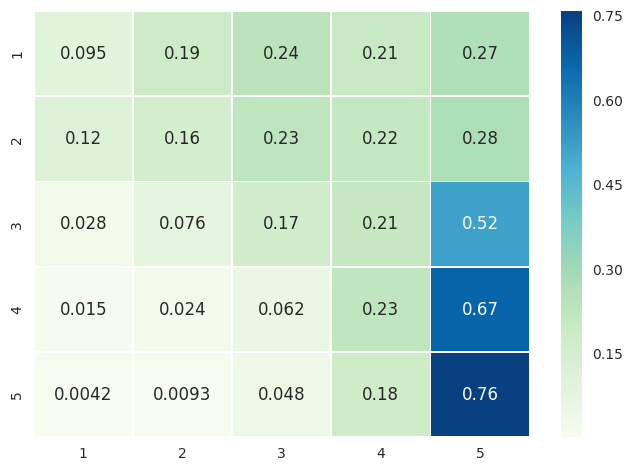

In [501]:
model = DecisionTreeClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_holdout)
print_and_plot_confusion_matrix(y_holdout, y_pred, class_names)

In [502]:
print(model.feature_importances_)

[ 0.07  0.15  0.06  0.05  0.03  0.03  0.04  0.06  0.03  0.04  0.04  0.03
  0.05  0.04  0.03  0.03  0.03  0.03  0.03  0.03  0.04  0.03  0.03]


## Let's improve the model... it looks like we could do this better with fewer topics, due to possible redundancies in the previously reported NMF

In [503]:
df.head()

,title,stars,content,full_content,rating,length,polarity,subjectivity
0,Small room big beds,4 of 5 bubbles,"\nAfter we got used to the cramped quarters, I...",Small room big beds. \nAfter we got used to th...,4,255,0.189063,0.558333
1,GREAT FIND,5 of 5 bubbles,\nWanted something a little away from Midtown;...,GREAT FIND. \nWanted something a little away f...,5,275,0.391121,0.610714
2,Wonderful Stay,5 of 5 bubbles,\nWe spent our wedding night at the Pierre and...,Wonderful Stay. \nWe spent our wedding night a...,5,276,0.390278,0.700000
3,Fantastic funky hotel!,5 of 5 bubbles,\nWhat a funky modern hotel. Check was so easy...,Fantastic funky hotel!. \nWhat a funky modern ...,5,224,0.325298,0.619048
4,All around wonderful experience,5 of 5 bubbles,\nRecently stayed at the hotel for a meeting a...,All around wonderful experience. \nRecently st...,5,241,0.637500,0.691667


### Use this model to try varying the parameters

In [567]:
result2.rating.value_counts()

5.0    14526
4.0     3853
3.0     1053
2.0      354
1.0      224
Name: rating, dtype: int64

In [584]:
doc_list = df['full_content']
tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                  ngram_range=(2, 4), stop_words='english',
                                  min_df=30, max_df=0.75)
tfidf_vectorizer.fit(doc_list)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=30,
        ngram_range=(2, 4), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [585]:
text_matrix = tfidf_vectorizer.transform(df['full_content'])
text_matrix

<20010x2708 sparse matrix of type '<class 'numpy.float64'>'
	with 230623 stored elements in Compressed Sparse Row format>

In [586]:
#step 3: throw a model at it
model = NMF(init="nndsvd", n_components=15, max_iter=1000) # n_comp = # topics
W = model.fit_transform(text_matrix) 
H = model.components_
words = tfidf_vectorizer.get_feature_names()

In [587]:
for topic_index in range( H.shape[0] ):
    top_indices = np.argsort( H[topic_index,:] )[::-1][0:20]
    term_ranking = [words[i] for i in top_indices]
    print ("Topic %d: %s" % ( topic_index, ", ".join( term_ranking ) ))

print (H.shape) # H is topics by words matrix

Topic 0: great location, location great, great location great, staff great, friendly staff, staff great location, great staff, hotel great location, location great staff, great location nice, great location staff, location nice, location staff, great location friendly, location friendly, service great, great location hotel, great location close, great location great staff, stay great location
Topic 1: chelsea pines, pines inn, chelsea pines inn, stayed chelsea pines, stayed chelsea, stay chelsea, stay chelsea pines, stayed chelsea pines inn, stay chelsea pines inn, chelsea market, high line, staying chelsea, staying chelsea pines, trip advisor, greenwich village, jay staff, staff chelsea, staff chelsea pines, nights chelsea pines, nights chelsea
Topic 2: new york, new york city, york city, hotel new york, hotel new, trip new york, trip new, stay new, stay new york, new york hotel, york hotel, visit new, visit new york, time new, time new york, hotel new york city, york stayed, new york

In [588]:
topic_names_10 = ["topic_0","topic_1","topic_2","topic_3","topic_4",
               "topic_5","topic_6","topic_7","topic_8","topic_9"
              ]
topic_names_15 = ["topic_0","topic_1","topic_2","topic_3","topic_4",
               "topic_5","topic_6","topic_7","topic_8","topic_9",
               "topic_10","topic_11","topic_12","topic_13","topic_14"
              ]

In [589]:
topics2 = pd.DataFrame(W,index=None,columns=topic_names_15)

In [590]:
topic_df.head()

,full_content,rating,length,polarity,subjectivity
0,Small room big beds. \nAfter we got used to th...,4,255,0.189063,0.558333
1,GREAT FIND. \nWanted something a little away f...,5,275,0.391121,0.610714
2,Wonderful Stay. \nWe spent our wedding night a...,5,276,0.390278,0.700000
3,Fantastic funky hotel!. \nWhat a funky modern ...,5,224,0.325298,0.619048
4,All around wonderful experience. \nRecently st...,5,241,0.637500,0.691667


In [591]:
result2 = pd.concat([topic_df, topics2], axis=1)

In [592]:
result2.head()

,full_content,rating,length,polarity,subjectivity,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,Small room big beds. \nAfter we got used to th...,4.0,255.0,0.189063,0.558333,0.010276,0.000000,0.000056,0.000232,0.000965,0.001101,0.004811,0.000000,0.013502,0.000334,0.000000,0.005518,0.000047,0.000259,0.000000
1,GREAT FIND. \nWanted something a little away f...,5.0,275.0,0.391121,0.610714,0.001202,0.000000,0.000560,0.000000,0.001175,0.000132,0.000551,0.003511,0.001390,0.000000,0.000000,0.060716,0.001604,0.000000,0.000000
2,Wonderful Stay. \nWe spent our wedding night a...,5.0,276.0,0.390278,0.700000,0.000000,0.003151,0.000081,0.000169,0.000076,0.000014,0.000000,0.001142,0.010797,0.000110,0.000214,0.000472,0.003876,0.001339,0.000000
3,Fantastic funky hotel!. \nWhat a funky modern ...,5.0,224.0,0.325298,0.619048,0.000000,0.000456,0.000000,0.000380,0.003140,0.000792,0.001301,0.001983,0.003902,0.000000,0.000000,0.003774,0.001505,0.000038,0.002016
4,All around wonderful experience. \nRecently st...,5.0,241.0,0.637500,0.691667,0.000400,0.001450,0.000362,0.000000,0.000000,0.001352,0.000000,0.001192,0.017944,0.000021,0.001889,0.000000,0.006843,0.002849,0.000232


In [593]:
del result2["full_content"]
del result2["length"]

In [594]:
# save the result df to csv, just in case
# result2.to_csv("result2.csv")

In [595]:
print(result2.shape)
result2_clean = result2.dropna()
print(result2_clean.shape)

from sklearn.cross_validation import train_test_split
X, y = result2_clean.drop(['rating'], axis=1),result2_clean['rating']

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=42)
print(len(X),len(X_train),len(X_holdout))

(20014, 18)
(20006, 18)
20006 14004 6002


In [597]:
for name,model in models.items():
    model.fit(X_train,y_train)
    y_pred = model.predict(X_holdout)
    conf_matrix = confusion_matrix(y_holdout, y_pred)
    
    zero = conf_matrix[0,0]
    one = conf_matrix[1,1]
    two = conf_matrix[2,2]
    three = conf_matrix[3,3]
    four = conf_matrix[4,4]
    
    print('Model: '+name)
    print("Score: " + str(model.score(X_holdout,y_holdout)))
    print(classification_report(y_holdout, model.predict(X_holdout)))
#     print("Feature Importances: " +model.feature_importances_)
    
    print("Confusion Matrix/ Correct Predictions: ")
    print(str(zero), str(one), str(two), str(three), str(four))
    print("Total Non-Fives Accurately Guessed")
    print(zero+one+two+three)
    print("")
    print("---")
    print("")


Model: Decision Tree
Score: 0.590803065645
             precision    recall  f1-score   support

        1.0       0.22      0.25      0.24        63
        2.0       0.18      0.13      0.15       120
        3.0       0.12      0.13      0.13       327
        4.0       0.23      0.25      0.24      1184
        5.0       0.76      0.74      0.75      4308

avg / total       0.60      0.59      0.60      6002

Confusion Matrix/ Correct Predictions: 
16 16 43 295 3176
Total Non-Fives Accurately Guessed
370

---

Model: Random Forest
Score: 0.679106964345
             precision    recall  f1-score   support

        1.0       0.24      0.17      0.20        63
        2.0       0.23      0.11      0.15       120
        3.0       0.20      0.10      0.14       327
        4.0       0.22      0.10      0.14      1184
        5.0       0.75      0.90      0.82      4308

avg / total       0.60      0.68      0.63      6002

Confusion Matrix/ Correct Predictions: 
11 13 34 123 3895
Total

/Users/ANTARES/anaconda2/envs/snakes/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
